<a href="https://colab.research.google.com/github/montjoile/Meta-learning/blob/master/Dataset_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Code for testing Dataset bias

## Datasets:

The datasets used here are all for skin cancer 

* https://challenge2019.isic-archive.com/
* https://www.fc.up.pt/addi/ph2%20database.html
* http://derm.cs.sfu.ca/Welcome.html

\\


This notebook contains:

- Random splitting into test and training set
- Data augmentation on minority classes in the train set
- Experiment to detect dataset bias

\\

Notes:

- I used a random state of 42 on the train/test spllit for reproducible results, this will change to completely random on the final testing in the hpc.
- I used a very small batch of samples from the original dataset on this notebook. (3 samples per class, keeping the same ratio of classes). The reason was the limitation of Colab environment. The results of the same experiments with the full samples are expected to be similar that the ones obtained here.

\\

Observations:


- It is worth to note that the class proportion within the train and test set differ, one sign of dataset shift, but the model perform with very high accuracy on the test set, which is highly imbalanced, suggesting that there is no symtoms of data shift.

- Although a very simple CNN was used, it scored high accuracy (93.8%) on predicting which dataset an image is from, an evident sign of dataset bias.

- Cross validation will be performed further to average that result.  





\\

  

The experiment performed here is *Name that dataset!* which can be found  [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.208.2314&rep=rep1&type=pdf)

### Mount Google drive

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###Import Libraries

In [0]:
#install imbalaced-learn
!pip install imbalanced-learn
!pip install Augmentor


In [3]:
import pandas as pd
import numpy as np
import os
from keras.utils import np_utils
from sklearn.utils import shuffle, class_weight
from PIL import Image
from keras.preprocessing import image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import shutil
from keras.callbacks import ModelCheckpoint
from keras import models
from sklearn.model_selection import StratifiedKFold
from keras import optimizers
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score, confusion_matrix
import pandas as pd
from pathlib import Path
import time
import matplotlib.image as mpimg
import Augmentor

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Prepare data

In [0]:
#Full dataset
df_melanoma = pd.DataFrame()

In [0]:
#create dataset name codes
dataset_codename = {
    'addi-melanoma':1,
    'derm7pt-melanoma':2,
    'skin-melanoma':3
}

#####Addi-melanoma dataset

In [0]:
#atypical-nevus
p = Path('/content/drive/My Drive/meta-learning/datasets/addi-melanoma/atypical-nevus/')
ds_codename = dataset_codename.get('addi-melanoma')

for image in p.rglob('*.*'):
  df_melanoma = df_melanoma.append({'filename':image.name, 'directory':str(image.parent), 'path':str(image.absolute()), 'dataset':ds_codename, 'dataset-name':'addi-melanoma', 'class':'atypical-nevus', 'subset':np.nan}, ignore_index=True)
#common-nevus
p = Path('/content/drive/My Drive/meta-learning/datasets/addi-melanoma/common-nevus/')
for image in p.rglob('*.*'):
  df_melanoma = df_melanoma.append({'filename':image.name, 'directory':str(image.parent), 'path':str(image.absolute()), 'dataset':ds_codename, 'dataset-name':'addi-melanoma', 'class':'common-nevus', 'subset':np.nan}, ignore_index=True)

p = Path('/content/drive/My Drive/meta-learning/datasets/addi-melanoma/melanoma/')
for image in p.rglob('*.*'):
  df_melanoma = df_melanoma.append({'filename':image.name, 'directory':str(image.parent), 'path':str(image.absolute()), 'dataset':ds_codename, 'dataset-name':'addi-melanoma', 'class':'melanoma', 'subset':np.nan}, ignore_index=True)    

#####Derm7pt-melanoma dataset

In [0]:

#derm7pt-melanoma
#test
listOfFiles = os.listdir('/content/drive/My Drive/meta-learning/datasets/derm7pt-melanoma/test')  
ds_codename = dataset_codename.get('derm7pt-melanoma')

for entry in listOfFiles:
  p = Path('/content/drive/My Drive/meta-learning/datasets/derm7pt-melanoma/test/'+entry)
  for image in p.rglob('*.*'):
    df_melanoma = df_melanoma.append({'filename':image.name, 'directory':str(image.parent), 'path':str(image.absolute()), 'dataset':ds_codename, 'dataset-name':'derm7pt-melanoma', 'class':entry, 'subset':'test'}, ignore_index=True)
#train
listOfFiles = os.listdir('/content/drive/My Drive/meta-learning/datasets/derm7pt-melanoma/train')  
for entry in listOfFiles:
  p = Path('/content/drive/My Drive/meta-learning/datasets/derm7pt-melanoma/train/'+entry)
  for image in p.rglob('*.*'):
    df_melanoma = df_melanoma.append({'filename':image.name, 'directory':str(image.parent), 'path':str(image.absolute()), 'dataset':ds_codename, 'dataset-name':'derm7pt-melanoma', 'class':entry, 'subset':'train'}, ignore_index=True)
#valid
listOfFiles = os.listdir('/content/drive/My Drive/meta-learning/datasets/derm7pt-melanoma/valid')  
for entry in listOfFiles:
  p = Path('/content/drive/My Drive/meta-learning/datasets/derm7pt-melanoma/valid/'+entry)
  for image in p.rglob('*.*'):
      df_melanoma = df_melanoma.append({'filename':image.name, 'directory':str(image.parent), 'path':str(image.absolute()), 'dataset':ds_codename, 'dataset-name':'derm7pt-melanoma', 'class':entry, 'subset':'valid'}, ignore_index=True)



#####Skin-melanoma dataset

In [0]:
   
listOfFiles = os.listdir('/content/drive/My Drive/meta-learning/datasets/skin-melanoma') 
ds_codename = dataset_codename.get('skin-melanoma')

for entry in listOfFiles:
  p = Path('/content/drive/My Drive/meta-learning/datasets/skin-melanoma/'+entry)
  for image in p.rglob('*.*'):
      df_melanoma = df_melanoma.append({'filename':image.name, 'directory':str(image.parent), 'path':str(image.absolute()), 'dataset':ds_codename, 'dataset-name':'skin-melanoma', 'class':entry, 'subset':np.nan}, ignore_index=True)
      

#####Visualize dataset

In [11]:
df_melanoma.tail()

,class,dataset,dataset-name,directory,filename,path,subset
188,squamous_cell_carcinoma,3.0,skin-melanoma,/content/drive/My Drive/meta-learning/datasets...,ISIC_0024329.jpg,/content/drive/My Drive/meta-learning/datasets...,NaN
189,squamous_cell_carcinoma,3.0,skin-melanoma,/content/drive/My Drive/meta-learning/datasets...,ISIC_0024418.jpg,/content/drive/My Drive/meta-learning/datasets...,NaN
190,vascular_lesion,3.0,skin-melanoma,/content/drive/My Drive/meta-learning/datasets...,ISIC_0024402.jpg,/content/drive/My Drive/meta-learning/datasets...,NaN
191,vascular_lesion,3.0,skin-melanoma,/content/drive/My Drive/meta-learning/datasets...,ISIC_0024375.jpg,/content/drive/My Drive/meta-learning/datasets...,NaN
192,vascular_lesion,3.0,skin-melanoma,/content/drive/My Drive/meta-learning/datasets...,ISIC_0024370.jpg,/content/drive/My Drive/meta-learning/datasets...,NaN


In [12]:
#count classes
Counter(df_melanoma['dataset-name'])

Counter({'addi-melanoma': 9, 'derm7pt-melanoma': 160, 'skin-melanoma': 24})

###Data augmentation 

In [0]:
#split in train and test set index
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X = df_melanoma['path']
y = df_melanoma['dataset-name']

# train is now 75% of the entire data set
x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(X, y, test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_train_idx, x_val_idx, y_train_idx, y_val_idx = train_test_split(x_train_idx, y_train_idx, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 


In [0]:
#path to images
x_train = df_melanoma[df_melanoma['path'].isin(x_train_idx)]
x_test = df_melanoma[df_melanoma['path'].isin(x_test_idx)]
x_val = df_melanoma[df_melanoma['path'].isin(x_val_idx)]

In [15]:
#check size
print(df_melanoma.shape)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(193, 7)
(86, 7)
(49, 7)
(58, 7)


In [16]:
#check label proportion
print('TRAIN '+str(Counter(y_train_idx)))
print('TEST '+str(Counter(y_test_idx)))
print('VAL '+str(Counter(y_val_idx)))

TRAIN Counter({'derm7pt-melanoma': 69, 'skin-melanoma': 13, 'addi-melanoma': 4})
TEST Counter({'derm7pt-melanoma': 46, 'skin-melanoma': 2, 'addi-melanoma': 1})
VAL Counter({'derm7pt-melanoma': 45, 'skin-melanoma': 9, 'addi-melanoma': 4})


In [0]:
#get indices of minority class in train set to augment
#addi-melanoma
addi_melanoma = x_train[x_train['dataset-name'] == 'addi-melanoma']
#skin-melanoma
skin_melanoma = x_train[x_train['dataset-name'] == 'skin-melanoma']

In [0]:
#calculate number of augmentations per image in minority classes from train set
#larger class // minority class = # of augmentation to perform per image
#addi-melanoma
addi_aug = 69//4
#skin-melanoma
skin_aug = 69//13

In [19]:
#augment images class addi-melanoma
for path in addi_melanoma['directory']:
  p = Augmentor.Pipeline(path)
  p.random_distortion(probability=0.2, grid_width=4, grid_height=4, magnitude=8)
  p.flip_left_right(probability=0.5)
  p.flip_top_bottom(probability=0.5)
  p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
  p.sample(addi_aug)
  
#augment images class skin-melanoma
for path in skin_melanoma['directory']:
  p = Augmentor.Pipeline(path)
  p.random_distortion(probability=0.2, grid_width=4, grid_height=4, magnitude=8)
  p.flip_left_right(probability=0.5)
  p.flip_top_bottom(probability=0.5)
  p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
  p.sample(skin_aug)  

Executing Pipeline:   0%|          | 0/17 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/addi-melanoma/atypical-nevus/output.

Processing <PIL.Image.Image image mode=RGB size=765x573 at 0x7F0F1D8CC7B8>: 100%|██████████| 17/17 [00:01<00:00, 14.68 Samples/s]
Executing Pipeline:   0%|          | 0/17 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/addi-melanoma/common-nevus/output.

Processing <PIL.Image.Image image mode=RGB size=766x575 at 0x7F0F1D059518>: 100%|██████████| 17/17 [00:01<00:00, 13.28 Samples/s]
Executing Pipeline:   0%|          | 0/17 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/addi-melanoma/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F0F1D059CF8>: 100%|██████████| 17/17 [00:01<00:00, 12.05 Samples/s]
Executing Pipeline:   0%|          | 0/17 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/addi-melanoma/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F0F1D8CCD30>: 100%|██████████| 17/17 [00:00<00:00, 17.55 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/actinic_keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D8CC630>: 100%|██████████| 5/5 [00:00<00:00,  9.50 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059CF8>:  20%|██        | 1/5 [00:00<00:00,  6.00 Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/basal_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059080>: 100%|██████████| 5/5 [00:00<00:00, 19.19 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D0596D8>:  20%|██        | 1/5 [00:00<00:00,  6.20 Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/basal_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059C88>: 100%|██████████| 5/5 [00:00<00:00, 20.80 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/basal_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059F98>: 100%|██████████| 5/5 [00:00<00:00, 17.35 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/benign_keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x680 at 0x7F0F1D059240>: 100%|██████████| 5/5 [00:00<00:00,  7.07 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D8CC6D8>: 100%|██████████| 5/5 [00:00<00:00, 15.07 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059B38>:  20%|██        | 1/5 [00:00<00:00,  5.33 Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D8CC780>: 100%|██████████| 5/5 [00:00<00:00,  7.13 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0F1D059CC0>: 100%|██████████| 5/5 [00:00<00:00,  6.64 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1022x767 at 0x7F0F1D0599E8>: 100%|██████████| 5/5 [00:00<00:00,  6.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059550>:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/squamous_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059048>: 100%|██████████| 5/5 [00:00<00:00, 19.17 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/squamous_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059710>: 100%|██████████| 5/5 [00:00<00:00, 14.27 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/vascular_lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D059860>: 100%|██████████| 5/5 [00:00<00:00,  3.32 Samples/s]
Executing Pipeline:   0%|          | 0/5 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to /content/drive/My Drive/meta-learning/datasets/skin-melanoma/vascular_lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F1D069240>: 100%|██████████| 5/5 [00:00<00:00, 14.54 Samples/s]


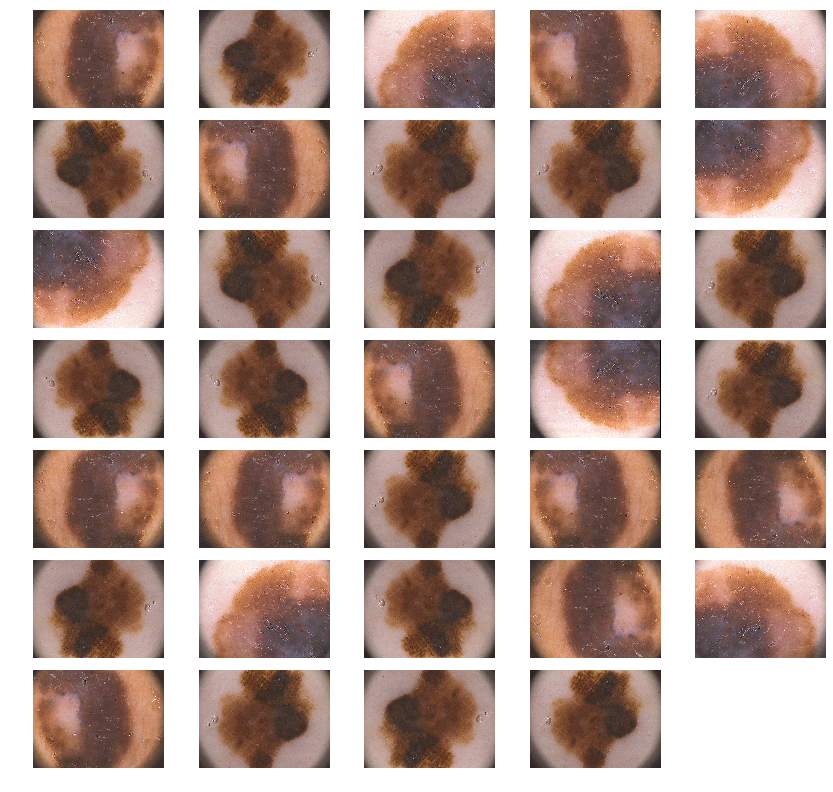

In [20]:
#plot augmented images class addi-melanoma

p = Path('/content/drive/My Drive/meta-learning/datasets/addi-melanoma/melanoma/output')
plt.figure(figsize=(30,20))
for image,i in zip(p.rglob('*.*'), range(1,68)):
  plt.subplot(10, 5, i)
  img=mpimg.imread(image)
  plt.imshow(img)
  plt.axis('Off')
plt.subplots_adjust(wspace=0.12, hspace=0.12, left =0.125, right=0.5)
plt.show()

In [0]:
#get all output paths of augmented images
output_paths = []
p = Path('/content/drive/My Drive/meta-learning/datasets/')
for i in p.rglob('output'):
  output_paths.append(str(i.absolute()))

In [0]:
#augmented train dataset
x_train_aug = x_train.copy()

for output_path in output_paths:
  p = Path(output_path)
  fl = len(p.parts)
  class_name = p.parts[fl-2]
  dataset_name = p.parts[fl-3]

  for image in p.rglob('*.*'):
    x_train_aug = x_train_aug.append({'filename':image.name, 'directory':str(image.parent), 'path':str(image.absolute()), 'dataset':dataset_codename.get(dataset_name), 'dataset-name':dataset_name, 'class':class_name, 'subset':np.nan}, ignore_index=True)
    

In [23]:
Counter(x_train_aug['dataset-name'])

Counter({'addi-melanoma': 72, 'derm7pt-melanoma': 69, 'skin-melanoma': 78})

###Experiment

In [43]:
#calculate proportion to augment
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(x_train_aug['dataset-name']),
                                                 x_train_aug['dataset-name'])
class_weights

array([1.01388889, 1.05797101, 0.93589744])

In [25]:
#data generator on training set

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
        dataframe=x_train_aug,
        x_col='path',
        y_col='dataset-name',
        directory='./train',
        target_size=(256, 256),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical')

Found 219 validated image filenames belonging to 3 classes.


In [0]:
# build cnn
from keras import models

model = Sequential()

model.add(Conv2D(16, 9, padding='same', input_shape=(256,256,3), use_bias=False))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())


model.add(Flatten())
model.add(Dense(512, activation='sigmoid', use_bias=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(activation='softmax', units=3))

model.compile(loss='categorical_crossentropy', 
              optimizer = keras.optimizers.SGD(
                  lr=0.01, 
                  momentum=0.9, 
                  nesterov=True),
              metrics=["accuracy"])

In [46]:
#test datagen
testgen = ImageDataGenerator()
test_generator = testgen.flow_from_dataframe(
                          dataframe=x_test,
                          x_col='path',
                          y_col='dataset-name',
                          directory='./test',
                          target_size=(256, 256),
                          batch_size=100,
                          shuffle=False,
                          color_mode='rgb',
                          class_mode='categorical')

Found 49 validated image filenames belonging to 3 classes.


In [47]:
# fit model on the augmented dataset
nb_epochs = 3 #number that divided by the total samples is an integer
samples_epoch = x_train_aug.shape[0] // nb_epochs
history = model.fit_generator(train_generator, samples_per_epoch=samples_epoch, nb_epoch=nb_epochs)#, class_weight=class_weights) #107

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=2, epochs=3)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/3
2/2 [==============================] - 19s 9s/step - loss: 2.8904 - acc: 0.4375
Epoch 2/3
2/2 [==============================] - 11s 5s/step - loss: 1.0218 - acc: 0.8213
Epoch 3/3
2/2 [==============================] - 12s 6s/step - loss: 0.3662 - acc: 0.9062


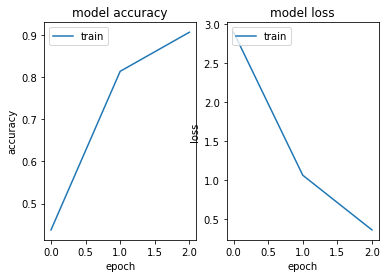

In [48]:
# list all data in history

accuracy_model = history.history['acc']
loss_model = history.history['loss']

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
#get predictions
true_labels = test_generator.classes
predictions = model.predict_generator(test_generator, steps=x_test.shape[0]//32)#, steps=49//32)
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

In [50]:
print(len(y_true)) 
print(len(y_pred)) 

49
49


In [51]:
#confusion matrix
confusion_matrix(y_true, y_pred)

array([[ 0,  1,  0],
       [ 0, 46,  0],
       [ 0,  2,  0]])

In [52]:
#classification report
print(classification_report(test_generator.classes, y_pred, target_names=dataset_codename))


                  precision    recall  f1-score   support

   addi-melanoma       0.00      0.00      0.00         1
derm7pt-melanoma       0.94      1.00      0.97        46
   skin-melanoma       0.00      0.00      0.00         2

        accuracy                           0.94        49
       macro avg       0.31      0.33      0.32        49
    weighted avg       0.88      0.94      0.91        49



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
#evaluate model 
model.evaluate_generator(test_generator, x_test.shape[0]/32, workers=1)

[0.833820104598999, 0.9387755393981934]